In [167]:
import json
from itertools import islice
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pprint

# Import geoplot
import geoplot
import geoplot.crs as gcrs
%matplotlib inline

#https://medium.com/@m_vemuri/create-a-geographic-heat-map-of-the-city-of-toronto-in-python-cd2ae0f8be55
import geopandas as gpd
from geopandas.tools import sjoin

# Load in all of our data

# Madison population
mad_pop_dirty = gpd.read_file('datasets/acs2021_5yr_B01003_14000US55025011407/acs2021_5yr_B01003_14000US55025011407.geojson')

# Clean out the bad data
mad_pop = mad_pop_dirty.copy()
mad_pop = mad_pop_dirty.loc[(mad_pop_dirty['B01003001'] > 0) & (mad_pop_dirty['B01003001'] < 20000)]

gdf = gpd.GeoDataFrame(mad_pop)
gdf.to_file('datasets/clean_population.geojson', driver='GeoJSON')

# Load in JSON for Madison population -- will be used for Choropleth maps later
mad_pop_json = json.load(open('datasets/clean_population.geojson'))


# Load in census tracts from ACS data
mad_map = gpd.read_file('datasets/Household_Size_By_Vehicles_Available/Household_Size_By_Vehicles_Available.geojson')

#metada = json.load(open('datasets/Household_Size_By_Vehicles_Available/metadata.json'))

# Bus stops and ridership stats
mad_bus_riders = gpd.read_file('datasets/Metro_Transit_Ridership_By_Stop.geojson')

# BRT route
brt = gpd.read_file('datasets/Bus_Rapid_Transit_System_Lines.geojson')

# Household income in 2021 (5yr estimates)
income = gpd.read_file('datasets/Income_Madison_2021_5yr/Income_Madison_2021_5yr.geojson')

income_meta = json.load(open('datasets/Income_Madison_2021_5yr/metadata.json'))
pprint.pprint(income['B19001002'])

#print(income)

0     54.0
1     44.0
2     29.0
3     42.0
4     61.0
      ... 
77    32.0
78    13.0
79    21.0
80     0.0
81     0.0
Name: B19001002, Length: 82, dtype: float64


In [175]:
income_keys = ['B19001002','B19001003','B19001004','B19001005','B19001006','B19001007','B19001008','B19001009', \
        'B19001010','B19001011','B19001012','B19001013','B19001014','B19001015', 'B19001016'] # last one is 150-200 K

income_vals = [5000,12500,17500,22500,27500,32500,37500,42500,47500,55000,67500,87500,112500,137500,175000]

assert len(income_keys) == len(income_vals), "Different lengths"

print(income['B19001002'][0])
ind = 0
key_ind = 0
mean_income = np.zeros(82)
for ind in range(82): # each census tract
    for key_ind in range(15): # each income bin
        mean_income[ind] += (income[income_keys[key_ind]][ind]*income_vals[key_ind]/income['B19001001'][ind])


income['mean_income_estimate'] = mean_income
print(income['mean_income_estimate'])

54.0
0     74192.164179
1     69365.079365
2     72974.230494
3     69816.000000
4     67216.178797
          ...     
77    74048.072850
78    86023.723569
79    70716.374269
80             NaN
81             NaN
Name: mean_income_estimate, Length: 82, dtype: float64


/var/folders/9t/skzkm_4169g47x95n5b3b5_h0000gn/T/ipykernel_46235/763334279.py:14: RuntimeWarning: invalid value encountered in scalar divide
  mean_income[ind] += (income[income_keys[key_ind]][ind]*income_vals[key_ind]/income['B19001001'][ind])


In [126]:
# Car overuse
mad_map = mad_map.merge(mad_pop[['name','B01003001']],how='left',on='name')

mad_map['overuse_total']= \
    mad_map['B08201011']+2*mad_map['B08201011']+3*mad_map['B08201012']+ \
    mad_map['B08201017']+2*mad_map['B08201018']+ \
    mad_map['B08201024']
mad_map['pop'] = mad_map['B01003001']
mad_map['overuse_rate'] = mad_map['overuse_total']/mad_map['pop']

# Limit
#mad_map = mad_map.loc[(mad_map['B08201001']>0) & (mad_map['B08201001']<10000)]

mad_map.head()

#fig, ax = plt.subplots(figsize=(10,8))

mad_map_filt = mad_map.loc[(mad_map['pop'] > 0) & (mad_map['pop'] < 20000)]

#mad_map.loc[(mad_map['B08201001']>0) & (mad_map['B08201001']<10000)].plot(column="overuse_rate",ax=ax,alpha=0.8,cmap='winter',legend=True)

In [134]:
mymap = sjoin(mad_bus_riders,mad_map.loc[(mad_map['B08201001']>0) & (mad_map['B08201001']<10000)], how='left')
map2 = mad_map.merge(mymap.groupby('name')['Weekday'].sum().reset_index(),how='left')

# Create log space version to see things better
# Divide by population to get ridership per population
map2['Weekday_normed']=np.log10(map2['Weekday']/map2['pop'])

<Axes: >

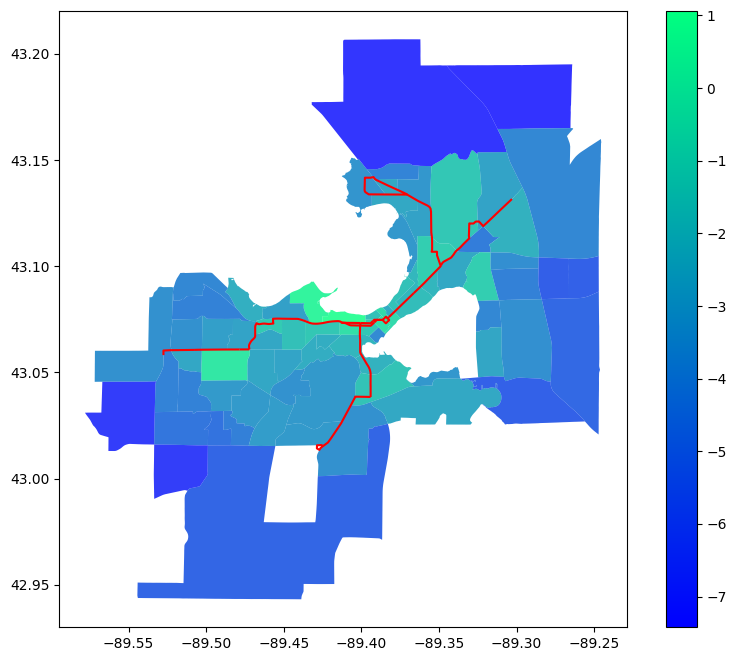

In [128]:
fig, ax = plt.subplots(figsize=(10,8))
map2.plot(column="Weekday_normed",ax=ax,alpha=0.8,cmap='winter',legend=True)
brt.plot(ax=ax,color='red')

In [149]:
# Calculate tract area in square km
map2['tract_area'] = map2['geometry'].to_crs({'init': 'epsg:3395'})\
               .map(lambda p: p.area / 10**6)
print(map2['tract_area'])

# Calculate population density
map2['pop_density'] = np.log10(map2['pop']/map2['tract_area'])

0       3.859515
1       3.435828
2       4.532606
3       4.925985
4       7.684088
         ...    
78      6.076778
79     29.087540
80     74.831785
81     25.575264
82    488.675084
Name: tract_area, Length: 83, dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [120]:
print(mad_map_filt.head)

<bound method NDFrame.head of                  geoid                           name  B08201001  \
0   14000US55025000100       Census Tract 1, Dane, WI     1340.0   
1   14000US55025000201    Census Tract 2.01, Dane, WI     1008.0   
2   14000US55025000202    Census Tract 2.02, Dane, WI     1397.0   
3   14000US55025000204    Census Tract 2.04, Dane, WI     2500.0   
4   14000US55025000205    Census Tract 2.05, Dane, WI     2528.0   
..                 ...                            ...        ...   
75  14000US55025011403  Census Tract 114.03, Dane, WI     1329.0   
76  14000US55025011404  Census Tract 114.04, Dane, WI     2605.0   
77  14000US55025011405  Census Tract 114.05, Dane, WI     2361.0   
78  14000US55025011406  Census Tract 114.06, Dane, WI     1939.0   
79  14000US55025011407  Census Tract 114.07, Dane, WI     1026.0   

    B08201001, Error  B08201002  B08201002, Error  B08201003  \
0              110.0       93.0              52.0      666.0   
1              219.0     

In [189]:
import folium
from branca.element import MacroElement

from jinja2 import Template

import pandas as pd


class BindColormap(MacroElement):
    """Binds a colormap to a given layer.

    Parameters
    ----------
    colormap : branca.colormap.ColorMap
        The colormap to bind.
    """
    def __init__(self, layer, colormap):
        super(BindColormap, self).__init__()
        self.layer = layer
        self.colormap = colormap
        self._template = Template(u"""
        {% macro script(this, kwargs) %}
            {{this.colormap.get_name()}}.svg[0][0].style.display = 'block';
            {{this._parent.get_name()}}.on('overlayadd', function (eventLayer) {
                if (eventLayer.layer == {{this.layer.get_name()}}) {
                    {{this.colormap.get_name()}}.svg[0][0].style.display = 'block';
                }});
            {{this._parent.get_name()}}.on('overlayremove', function (eventLayer) {
                if (eventLayer.layer == {{this.layer.get_name()}}) {
                    {{this.colormap.get_name()}}.svg[0][0].style.display = 'none';
                }});
        {% endmacro %}
        """)  # noqa



def remove_choro_legend(c, m):
    for key in c._children:
        if key.startswith('color_map'):
            branca_color_map = c._children[key]
            del(c._children[key])


    m.add_child(c)
    #m.add_child(folium.map.LayerControl())
    m.add_child(branca_color_map)
    m.add_child(BindColormap(c, branca_color_map))
    

In [191]:
from folium.plugins import HeatMap

# Create a base map
min_lat, max_lat = 42, 44
min_lon, max_lon = -90, -88

m = folium.Map(
    max_bounds=True,
    location=[43.0722, -89.401],
    zoom_start=12,
    min_lat=min_lat,
    max_lat=max_lat,
    min_lon=min_lon,
    max_lon=max_lon,
    tiles = 'cartodbpositron',
)
#m = folium.Map(location=[43.0722,-89.401], tiles='cartodbpositron', zoom_start=12)

#ct = folium.FeatureGroup(name="Census Tracts",control=True,show=False).add_to(m)
#folium.Choropleth(mad_map,highlight=True).add_to(ct)

#com = folium.FeatureGroup(name="Population",control=True,show=False).add_to(m)
ch1 = folium.Choropleth(
    geo_data=mad_pop_json,
    data=mad_pop,
    columns=["name","B01003001"],
    key_on="feature.properties.name",
    fill_color="YlGn",
    fill_opacity=0.4,
    line_opacity=0.2,
    legend_name="Population",
    show=False,
    highlight=True,
    name="Population"
)

ch2 = folium.Choropleth(
    geo_data=mad_pop_json,
    data=map2,
    columns=["name","pop_density"],
    key_on="feature.properties.name",
    fill_color="YlGn",
    fill_opacity=0.6,
    line_opacity=0.2,
    legend_name="Population/km^2 (log10)",
    show=False,
    highlight=True,
    name="Population Density"
)
#folium.LayerControl().add_to(m)

ch3 = folium.Choropleth(
    geo_data=mad_pop_json,
    data=map2,
    columns=["name","Weekday_normed"],
    key_on="feature.properties.name",
    fill_color="PuOr",
    fill_opacity=0.6,
    line_opacity=0.2,
    legend_name="Weekday Bus Rides per Capita (log10)",
    show=False,
    highlight=True,
    name="Bus Rides per Capita"
)
#folium.LayerControl().add_to(m)

ch4 = folium.Choropleth(
    geo_data=mad_pop_json,
    data=map2,
    columns=["name","overuse_rate"],
    key_on="feature.properties.name",
    fill_color="RdBu_r",
    fill_opacity=0.6,
    line_opacity=0.2,
    legend_name="Car Overuse",
    show=False,
    highlight=True,
    name="Car Overuse"
)

ch5 = folium.Choropleth(
    geo_data=mad_pop_json,
    data=income,
    columns=["name","mean_income_estimate"],
    key_on="feature.properties.name",
    fill_color="RdBu",
    fill_opacity=0.6,
    line_opacity=0.2,
    legend_name="Household Income",
    show=False,
    highlight=True,
    name="Household Income"
)

rapid_transit = folium.FeatureGroup(name="Rapid Transit Route",control=True,show=False).add_to(m)
folium.GeoJson(brt).add_to(rapid_transit)

# Heatmap has to take in lists of lists
bus_stops = mad_bus_riders[['Lat','Lon']]
bus_riders_weekday = mad_bus_riders[['Lat','Lon','Weekday']]

#fg = folium.FeatureGroup(name='Bus Stop Concentration',control=True,show=False).add_to(m)
#HeatMap(bus_stops,radius=15).add_to(fg)
fg1 = folium.FeatureGroup(name='Bus Ridership',control=True,show=False).add_to(m)
HeatMap(bus_riders_weekday,radius=15).add_to(fg1)


choro_maps = [ch1,ch2, ch3, ch4, ch5]
for c in choro_maps:
    remove_choro_legend(c,m)

m.add_child(folium.LayerControl())
#folium.LayerControl().add_to(new_map)

# Display the map
m

In [192]:
# Save map to html

m.save('interactive_map.html')